# Gender Bias - Analisi metriche di fairness e uso di explainer

Caricamento delle librerie necessarie: 
- **numpy** e **pandas** per la manipolazione dei dati;
- **sklearn** per utilizzare alcuni modelli di machine learning già pronte e alcune utility per la preparazione dei dati;
- **shap** per costruire gli explainer dei modelli.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import shap

Definizione del seed per la riproducibilità:

In [2]:
np.random.seed(42)

Generazione di un dataset simulato di 1000 campini con le seguenti caratteristiche:

- **gender**: genere del cliente (binomiale p=0.5);
- **age**: età del cliente (normale con $\mu$=35 anni, $\sigma$=10 anni);
- **income**: reddito del cliente (normale con $\mu$=50 k€, $\sigma$=15 k€);
- **credit_score**: punteggio di credito (FICO score) del cliente (normale con $\mu$=700, $\sigma$=50);
- **life_expectancy**: aspettativa di vita, più alta per le donne (normale con $\mu$=85 anni, $\sigma$=5 anni) e più bassa per gli uomini (normale con $\mu$=80 anni, $\sigma$=5 anni);
- **credit_approved**: variabile booleana di approvazione o meno del credito, con un bias verso le donne per costruzione;
- **life_policy**: variabile booleana di stipula della polizza vita, determinata in funzione dell'aspettativa di vita.

In [3]:
n = 1000
gender = np.random.choice(['Male', 'Female'], n, p=[0.5, 0.5])
age = np.random.normal(35, 10, n)
income = np.random.normal(50000, 15000, n)
credit_score = np.random.normal(700, 50, n)
life_expectancy = np.where(gender == 'Female', np.random.normal(85, 5, n), np.random.normal(80, 5, n))
credit_approved = np.where(
    (gender == 'Female') & (np.random.rand(n) < 1 / (1 + np.exp(-(credit_score - 630) / 50))),
    'Yes',
    np.where((gender == 'Male') & (np.random.rand(n) < 1 / (1 + np.exp(-(credit_score - 670) / 50))), 'Yes', 'No')
)
life_policy = np.where(np.random.rand(n) < 1 / (1 + np.exp(-(life_expectancy - 82.5) / 2.5)), 'Yes', 'No')

data = pd.DataFrame({
    'gender': gender,
    'age': age,
    'income': income,
    'credit_score': credit_score,
    'life_expectancy': life_expectancy,
    'credit_approved': credit_approved,
    'life_policy': life_policy
})

Divisione del dataset in un 80% per il training e un 20% per il test:

In [4]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

Conversione delle variabili categoriche (gender, credit_approved, life_policy) in numeriche e standardizzazione delle variabili continue (age, income, credit_score, life_expectancy) per migliorare la performance dei modelli:

In [5]:
def preprocess_data(df):
    df = df.copy()
    df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})
    df['credit_approved'] = df['credit_approved'].map({'No': 0, 'Yes': 1})
    df['life_policy'] = df['life_policy'].map({'No': 0, 'Yes': 1})
    return df

train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

scaler = StandardScaler()
train_data[['age', 'income', 'credit_score', 'life_expectancy']] = scaler.fit_transform(train_data[['age', 'income', 'credit_score', 'life_expectancy']])
test_data[['age', 'income', 'credit_score', 'life_expectancy']] = scaler.transform(test_data[['age', 'income', 'credit_score', 'life_expectancy']])

Addestramento del modello di concessione del credito utilizzando una regressione logistica:

In [6]:
credit_model = LogisticRegression(max_iter=1000)
credit_model.fit(train_data[['gender', 'age', 'income', 'credit_score']], train_data['credit_approved'])

LogisticRegression(max_iter=1000)

Addestramento del modello per la stipula della polizza vita utilizzando una regressione logistica:

In [7]:
life_model = LogisticRegression(max_iter=1000)
life_model.fit(train_data[['gender', 'age', 'income', 'life_expectancy']], train_data['life_policy'])

LogisticRegression(max_iter=1000)

Utilizzo dei modelli addestrati per fare previsioni sui dati di test:

In [8]:
credit_predictions = credit_model.predict(test_data[['gender', 'age', 'income', 'credit_score']])
life_predictions = life_model.predict(test_data[['gender', 'age', 'income', 'life_expectancy']])

Calcolo dei tassi di accettazione del credito e di stipula della polizza vita per genere per valutare la fairness dei modelli:

In [9]:
fairness_metrics = test_data.copy()
fairness_metrics['credit_predictions'] = credit_predictions
fairness_metrics['life_predictions'] = life_predictions

# Tasso di accettazione del credito per genere
credit_fairness = fairness_metrics.groupby('gender')['credit_predictions'].mean()
print("Credit Fairness:")
print(credit_fairness)

# Tasso di stipula della polizza vita per genere
life_fairness = fairness_metrics.groupby('gender')['life_predictions'].mean()
print("Life Policy Fairness:")
print(life_fairness)

Credit Fairness:
gender
0    0.790476
1    0.894737
Name: credit_predictions, dtype: float64
Life Policy Fairness:
gender
0    0.266667
1    0.757895
Name: life_predictions, dtype: float64


Si nota un evidente sbilanciamento della concessione del credito e della stipula della polizza vita (ancor maggiormente) nel caso di presenza di genere femminile.

Questa osservazione non necessariamente porta a concludere che il modello presenti un bias di genere, diventa rilevante comprendere l'importanza che ciascuna variabile ha all'interno del modello determinabile attraverso la costruzione di explainer attraverso la libraria SHAP.

In [10]:
explainer_credit = shap.Explainer(credit_model, train_data[['gender', 'age', 'income', 'credit_score']])
shap_values_credit = explainer_credit(test_data[['gender', 'age', 'income', 'credit_score']])

explainer_life = shap.Explainer(life_model, train_data[['gender', 'age', 'income', 'life_expectancy']])
shap_values_life = explainer_life(test_data[['gender', 'age', 'income', 'life_expectancy']])

Rappresentazione dell'importanza delle variabili:

Credit Model Variable Importance:


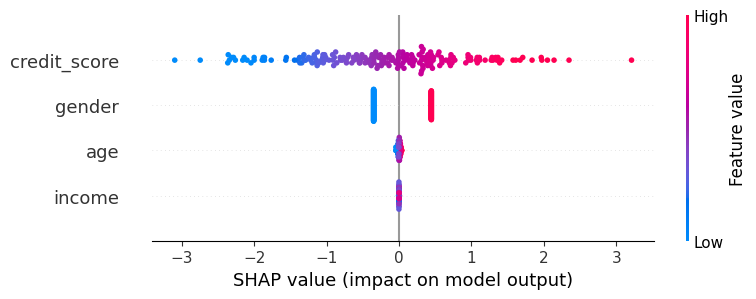

Life Policy Model Variable Importance:


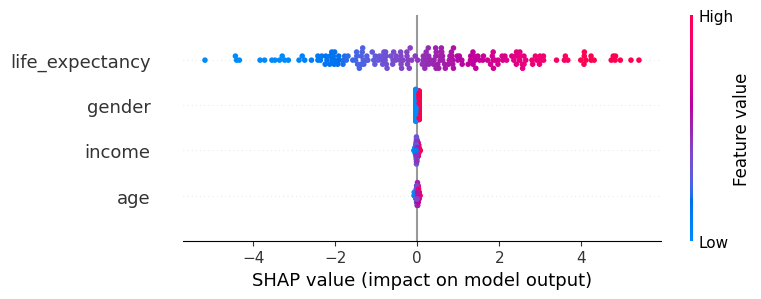

In [11]:
print("Credit Model Variable Importance:")
shap.summary_plot(shap_values_credit, test_data[['gender', 'age', 'income', 'credit_score']])

print("Life Policy Model Variable Importance:")
shap.summary_plot(shap_values_life, test_data[['gender', 'age', 'income', 'life_expectancy']])

I grafici mettono in luce che:
- nel modello di concessione del credito, il genere ha un impatto significativo sulle decisioni di approvazione;
- nel modello di stipula dell polizza vita, l'aspettativa di vita è la variabile predominante, rendendo evidente come le decisioni siano principalmente basate su fattori legittimi e non su discriinazioni di genere.